# End-to-End Classification Workflow Template

### See also:
- https://github.com/SalvatoreMaraniello/raylo-test/blob/master/studies/00-data-exploration.ipynb 

In [1]:
# --- 0. Setup: Import Libraries and Generate Dummy Data ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, average_precision_score


# --- 0.a Set Parameters
sns.set_palette("pastel", n_colors=10)
sns.color_palette("pastel",10)

# Set a random seed for reproducibility in data generation and modeling
np.random.seed(42) 

# --- Data Generation (for reproducible example) ---
# In a real scenario, you would load your data here (e.g., pd.read_csv('your_data.csv'))

num_samples = 1000


# 0. Create Dummy data


In [2]:
# Features: some numerical, some categorical, some with missing values, some skewed
data = {
    'numerical_feature_1': np.random.randn(num_samples) * 10 + 50,  # Normally distributed
    'numerical_feature_2': np.random.exponential(scale=2, size=num_samples), # Skewed
    'numerical_feature_3': np.random.randint(0, 100, num_samples),  # Integer counts
    'numerical_feature_4': np.random.rand(num_samples) * 100,  # Uniform
    'categorical_feature_1': np.random.choice(['A', 'B', 'C'], num_samples, p=[0.5, 0.3, 0.2]),
    'categorical_feature_2': np.random.choice(['X', 'Y'], num_samples, p=[0.7, 0.3]),
    'numerical_feature_with_nans': np.random.randn(num_samples) * 5 + 20 # Base for NaNs
}
df = pd.DataFrame(data)

# Introduce NaNs for demonstration
nan_indices = np.random.choice(df.index, size=int(num_samples * 0.05), replace=False)
df.loc[nan_indices, 'numerical_feature_with_nans'] = np.nan
nan_indices_cat = np.random.choice(df.index, size=int(num_samples * 0.03), replace=False)
df.loc[nan_indices_cat, 'categorical_feature_1'] = np.nan

# Target variable (binary classification)
# Make it somewhat dependent on features
df['target'] = (
    (df['numerical_feature_1'] > 55) * 0.3 +
    (df['numerical_feature_2'] > 2) * 0.4 +
    (df['categorical_feature_1'] == 'A') * 0.2 +
    (df['numerical_feature_with_nans'].fillna(20) > 25) * 0.1 + # Fillna for target generation logic
    np.random.rand(num_samples) * 0.5 # Add some noise
).apply(lambda x: 1 if x > 0.8 else 0)

print("--- Dummy Dataset Head ---")
display(df.head())

print("\n--- Dummy Dataset Info ---")
df.info()

print("\n--- Target Distribution ---")
print(df['target'].value_counts(normalize=True))

# Separate features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")

--- Dummy Dataset Head ---


,numerical_feature_1,numerical_feature_2,numerical_feature_3,numerical_feature_4,categorical_feature_1,categorical_feature_2,numerical_feature_with_nans,target
0,54.967142,0.366602,61,26.884674,A,X,21.989260,0
1,48.617357,0.220898,7,62.843405,NaN,X,25.083148,0
2,56.476885,2.023568,42,48.186748,A,X,18.980884,1
3,65.230299,2.451590,19,36.171025,B,Y,23.235492,1
4,47.658466,0.064191,96,94.920863,B,Y,21.551731,0



--- Dummy Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numerical_feature_1          1000 non-null   float64
 1   numerical_feature_2          1000 non-null   float64
 2   numerical_feature_3          1000 non-null   int64  
 3   numerical_feature_4          1000 non-null   float64
 4   categorical_feature_1        970 non-null    object 
 5   categorical_feature_2        1000 non-null   object 
 6   numerical_feature_with_nans  950 non-null    float64
 7   target                       1000 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 62.6+ KB

--- Target Distribution ---
target
0    0.733
1    0.267
Name: proportion, dtype: float64

Numerical Features: ['numerical_feature_1', 'numerical_feature_2', 'numerical_feature_3', 'numerical_feature_4', 'numerical_feature_

## 1. Data Exploration and Analysis

This section focuses on understanding the dataset's characteristics, distributions, relationships between features, and the presence of missing values. Visualizations are key here.

In [3]:
print("\n\n--- 1. Data Exploration and Analysis ---")

# 1.1 Basic Statistics
print("\n1.1 Basic Statistics (Numerical Features):")
print(X[numerical_features].describe())

print("\n1.1 Basic Statistics (Categorical Features):")
for col in categorical_features:
    print(f"\n{col} Value Counts:")
    print(X[col].value_counts(normalize=True))

# 1.2 Missing Values Analysis
print("\n1.2 Missing Values:")
display(X.isnull().sum())
print("\nMissing values percentage:")
display(X.isnull().sum() / len(X) * 100)



--- 1. Data Exploration and Analysis ---

1.1 Basic Statistics (Numerical Features):
       numerical_feature_1  numerical_feature_2  numerical_feature_3  \
count          1000.000000          1000.000000          1000.000000   
mean             50.193321             2.015972            49.268000   
std               9.792159             2.005977            28.348718   
min              17.587327             0.006447             0.000000   
25%              43.524097             0.567909            25.000000   
50%              50.253006             1.451862            48.000000   
75%              56.479439             2.743369            74.000000   
max              88.527315            14.883446            99.000000   

       numerical_feature_4  numerical_feature_with_nans  
count          1000.000000                   950.000000  
mean             51.001999                    19.950185  
std              28.408011                     4.993343  
min               0.201852      

numerical_feature_1             0
numerical_feature_2             0
numerical_feature_3             0
numerical_feature_4             0
categorical_feature_1          30
categorical_feature_2           0
numerical_feature_with_nans    50
dtype: int64


Missing values percentage:


numerical_feature_1            0.0
numerical_feature_2            0.0
numerical_feature_3            0.0
numerical_feature_4            0.0
categorical_feature_1          3.0
categorical_feature_2          0.0
numerical_feature_with_nans    5.0
dtype: float64

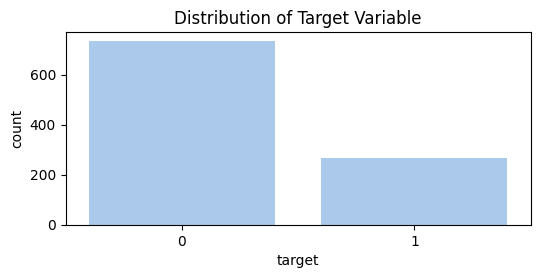

In [4]:
# 1.3 Target Variable Distribution (already printed in setup, but useful to visualize)
plt.figure(figsize=(6, 2.5))
sns.countplot(x=y)
plt.title('Distribution of Target Variable')
plt.show()

In [5]:
# --- Plotting Helper Function ---
N_COLS_PER_ROW = 5 # Define how many plots per row for most plots

def get_axes_for_subplots(num_items, cols_per_row, fig_width_per_plot=4, fig_height_per_plot=4):
    """
    Helper function to create a figure and a grid of subplots.
    Returns (fig, axes) where axes is flattened for easy iteration.
    Handles creation of single row/column axes array if num_items <= cols_per_row.
    """
    if num_items == 0:
        return None, None
    n_rows = int(np.ceil(num_items / cols_per_row))
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(fig_width_per_plot * cols_per_row, fig_height_per_plot * n_rows))
    
    # If only one row or one column, axes might not be a 2D array, so flatten it
    if num_items <= cols_per_row: # or n_rows == 1
        axes = np.atleast_1d(axes).flatten() # Ensure it's always iterable and flat
    else:
        axes = axes.flatten()
    
    # Hide any unused subplots
    for j in range(num_items, len(axes)):
        fig.delaxes(axes[j])
        
    return fig, axes

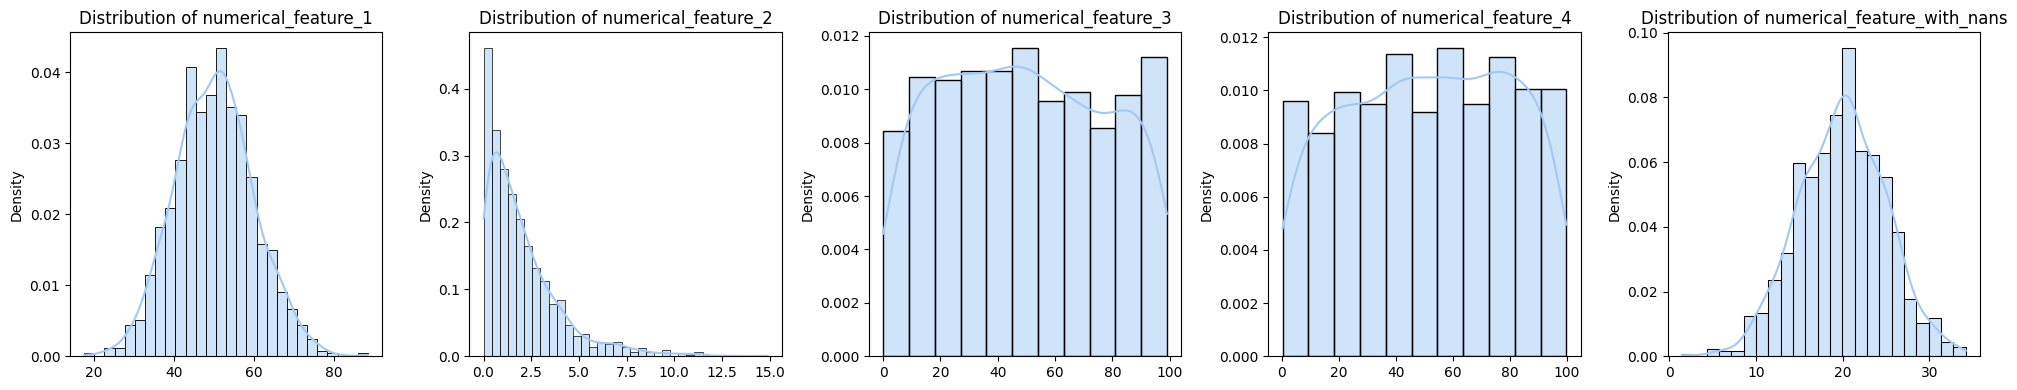

In [6]:
# 1.4 Univariate Plots (Distributions of Numerical Features)
fig_num_uni, axes_num_uni = get_axes_for_subplots(len(numerical_features), N_COLS_PER_ROW)
if fig_num_uni: # Check if plots were created
    for i, col in enumerate(numerical_features):
        sns.histplot(X[col], kde=True, ax=axes_num_uni[i], stat='density')
        axes_num_uni[i].set_title(f'Distribution of {col}')
        axes_num_uni[i].set_xlabel('') # Clear x-label to reduce clutter
    fig_num_uni.tight_layout()
    plt.show()


1.4 Univariate Plots (Distributions of Categorical Features):


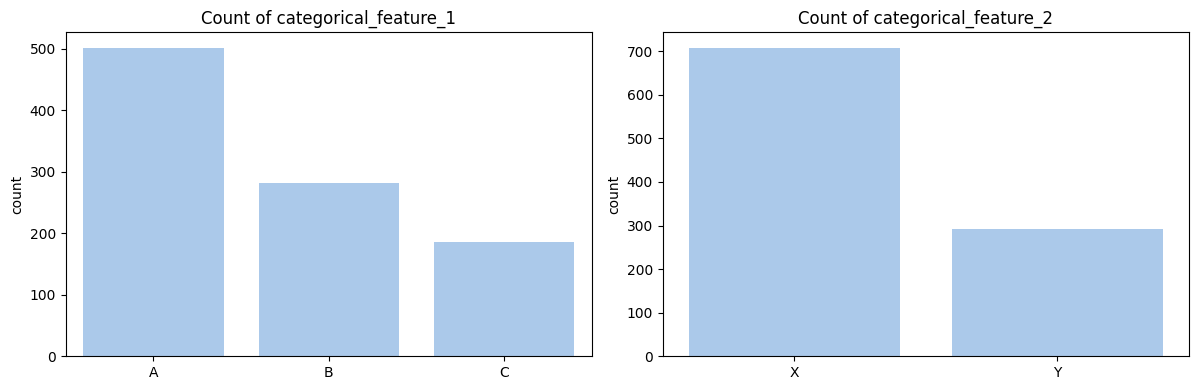

In [7]:
print("\n1.4 Univariate Plots (Distributions of Categorical Features):")
# Categorical plots might look better with fewer columns, or adjust fig_width_per_plot
fig_cat_uni, axes_cat_uni = get_axes_for_subplots(len(categorical_features), N_COLS_PER_ROW, fig_width_per_plot=6)
if fig_cat_uni:
    for i, col in enumerate(categorical_features):
        sns.countplot(x=X[col], order=X[col].value_counts().index, ax=axes_cat_uni[i])
        axes_cat_uni[i].set_title(f'Count of {col}')
        axes_cat_uni[i].set_xlabel('')
    fig_cat_uni.tight_layout()
    plt.show()


1.5 Bivariate Plots (Numerical Features vs. Target - Box Plots):


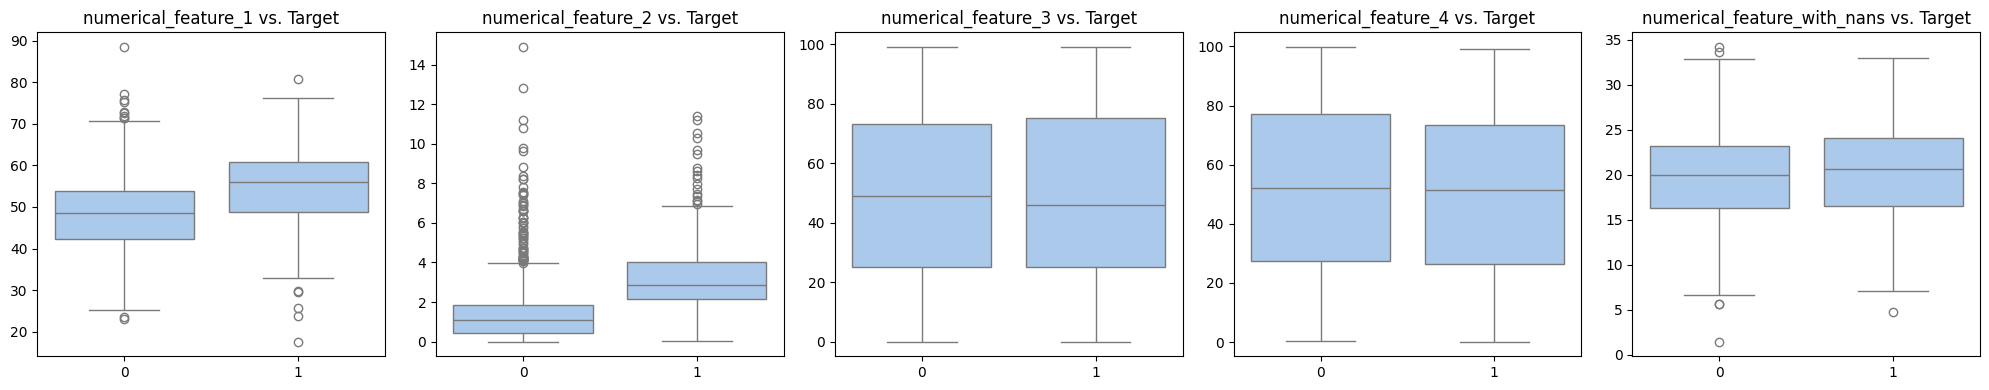

In [8]:
# 1.5 Bivariate Plots (Numerical Features vs. Target - Box Plots)
print("\n1.5 Bivariate Plots (Numerical Features vs. Target - Box Plots):")
fig_num_biv, axes_num_biv = get_axes_for_subplots(len(numerical_features), N_COLS_PER_ROW)
if fig_num_biv:
    for i, col in enumerate(numerical_features):
        sns.boxplot(x=y, y=X[col], ax=axes_num_biv[i])
        axes_num_biv[i].set_title(f'{col} vs. Target')
        axes_num_biv[i].set_xlabel('')
        axes_num_biv[i].set_ylabel('')
    fig_num_biv.tight_layout()
    plt.show()


1.5b Conditional Probability Distributions (Numerical Features vs. Target - Overlapping Densities):


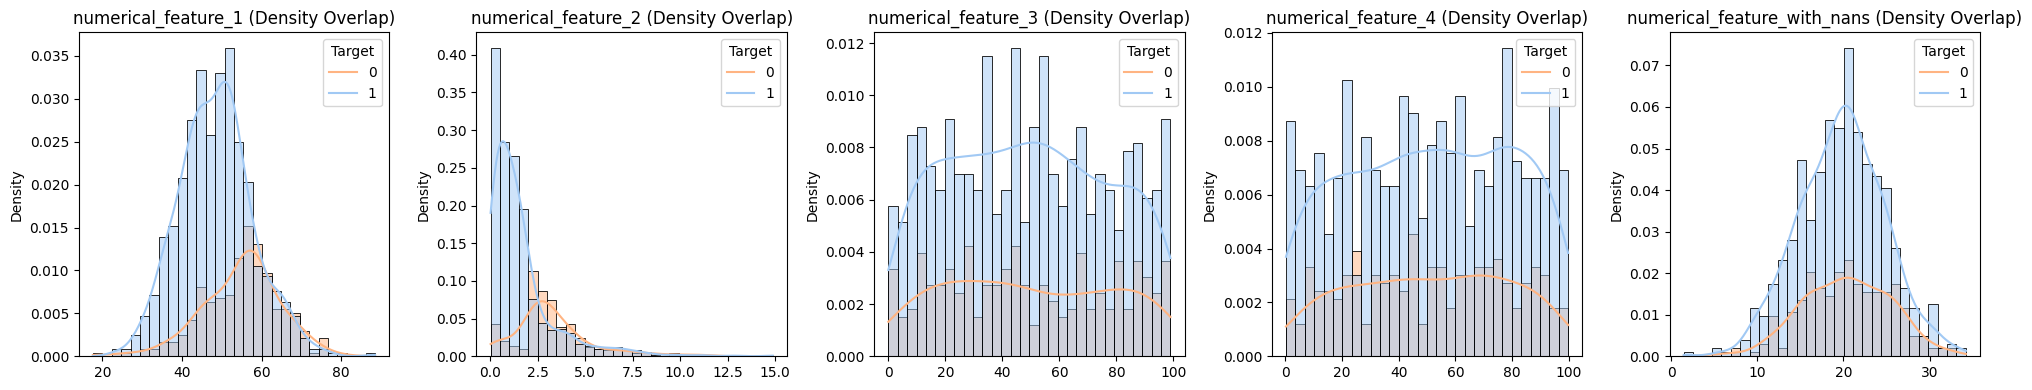


1.5c Stacked Conditional Density Plots (Numerical Features vs. Target - Sum = p(f=F)):


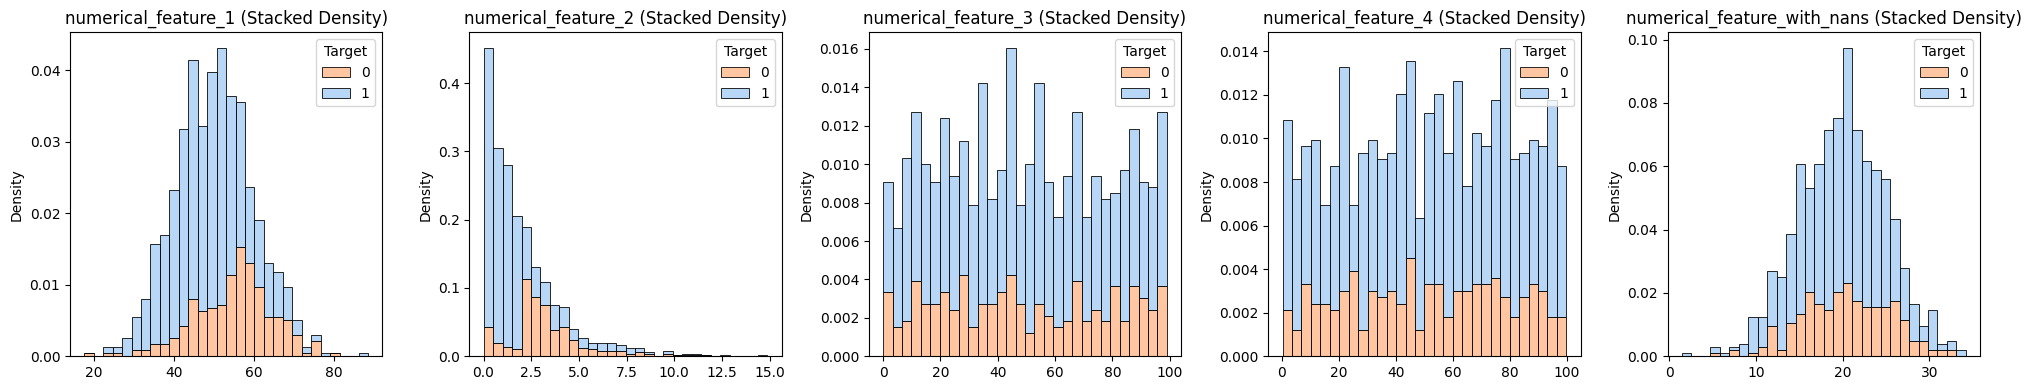


1.5d Stacked Conditional Proportion Plots (Numerical Features vs. Target - Sum = 1 per Bin):


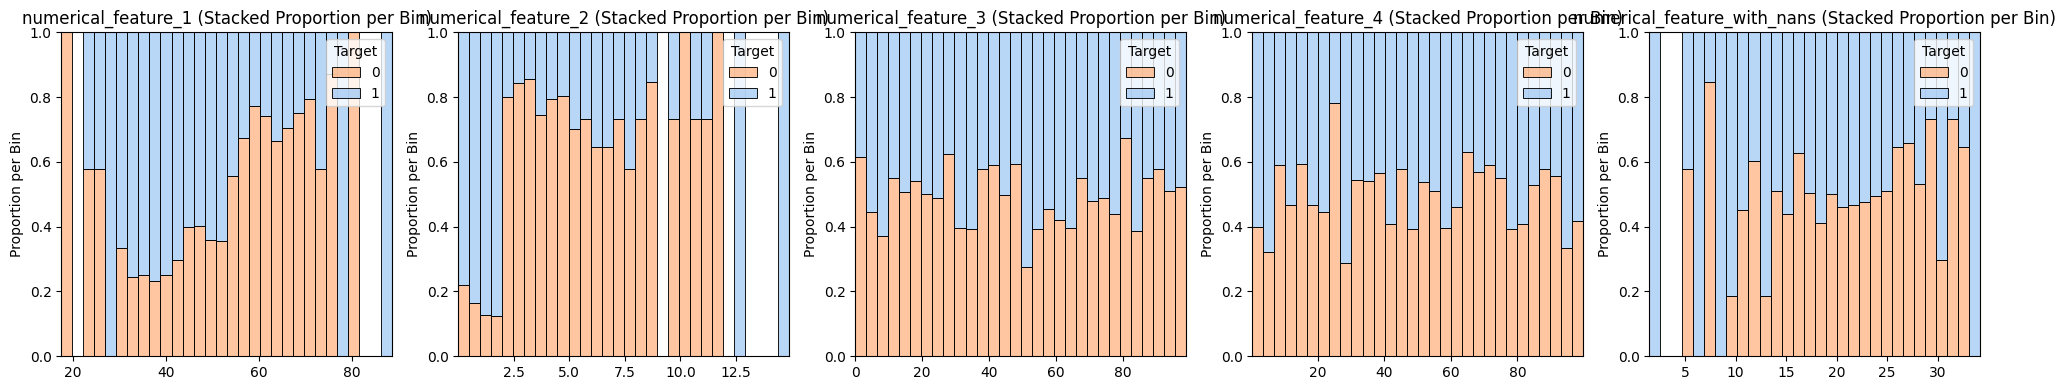

In [9]:
# 1.5b Conditional Probability Distributions (Numerical Features vs. Target) - Overlapping Densities
print("\n1.5b Conditional Probability Distributions (Numerical Features vs. Target - Overlapping Densities):")
fig_num_cond_overlap, axes_num_cond_overlap = get_axes_for_subplots(len(numerical_features), N_COLS_PER_ROW)
if fig_num_cond_overlap:
    for i, col in enumerate(numerical_features):
        sns.histplot(data=df, x=col, hue='target', kde=True, stat='density', common_norm=True, bins=30, ax=axes_num_cond_overlap[i])
        axes_num_cond_overlap[i].set_title(f'{col} (Density Overlap)')
        axes_num_cond_overlap[i].set_xlabel('')
        axes_num_cond_overlap[i].set_ylabel('Density')
        axes_num_cond_overlap[i].legend(title='Target', labels=['0', '1'], loc='upper right')
    fig_num_cond_overlap.tight_layout()
    plt.show()

# --- New Section for Stacked Density Plots (Sum = p(f=F)) ---
# 1.5c Stacked Conditional Density Plots (Numerical Features vs. Target) - Sum = p(f=F)
print("\n1.5c Stacked Conditional Density Plots (Numerical Features vs. Target - Sum = p(f=F)):")
fig_num_cond_stacked_density, axes_num_cond_stacked_density = get_axes_for_subplots(len(numerical_features), N_COLS_PER_ROW)
if fig_num_cond_stacked_density:
    for i, col in enumerate(numerical_features):
        sns.histplot(data=df, x=col, hue='target', kde=False, stat='density', multiple='stack',
                     common_norm=True, bins=30, ax=axes_num_cond_stacked_density[i])
        axes_num_cond_stacked_density[i].set_title(f'{col} (Stacked Density)')
        axes_num_cond_stacked_density[i].set_xlabel('')
        axes_num_cond_stacked_density[i].set_ylabel('Density')
        axes_num_cond_stacked_density[i].legend(title='Target', labels=['0', '1'], loc='upper right')
    fig_num_cond_stacked_density.tight_layout()
    plt.show()

# --- Stacked Proportion Plots (Sum = 1 per bin, i.e., p(t|f=F)) ---
# 1.5d Stacked Conditional Proportion Plots (Numerical Features vs. Target) - Sum = 1 per Bin
print("\n1.5d Stacked Conditional Proportion Plots (Numerical Features vs. Target - Sum = 1 per Bin):")
fig_num_cond_stacked_prop, axes_num_cond_stacked_prop = get_axes_for_subplots(len(numerical_features), N_COLS_PER_ROW)
if fig_num_cond_stacked_prop:
    for i, col in enumerate(numerical_features):
        sns.histplot(data=df, x=col, hue='target', kde=False, stat='proportion', multiple='fill',
                     common_norm=False, bins=30, ax=axes_num_cond_stacked_prop[i])
        axes_num_cond_stacked_prop[i].set_title(f'{col} (Stacked Proportion per Bin)')
        axes_num_cond_stacked_prop[i].set_xlabel('')
        axes_num_cond_stacked_prop[i].set_ylabel('Proportion per Bin')
        axes_num_cond_stacked_prop[i].set_ylim(0, 1) # Ensure y-axis shows proportions clearly
        axes_num_cond_stacked_prop[i].legend(title='Target', labels=['0', '1'], loc='upper right')
    fig_num_cond_stacked_prop.tight_layout()
    plt.show()


1.5e Bivariate Plots (Categorical Features vs. Target - Count Plots):


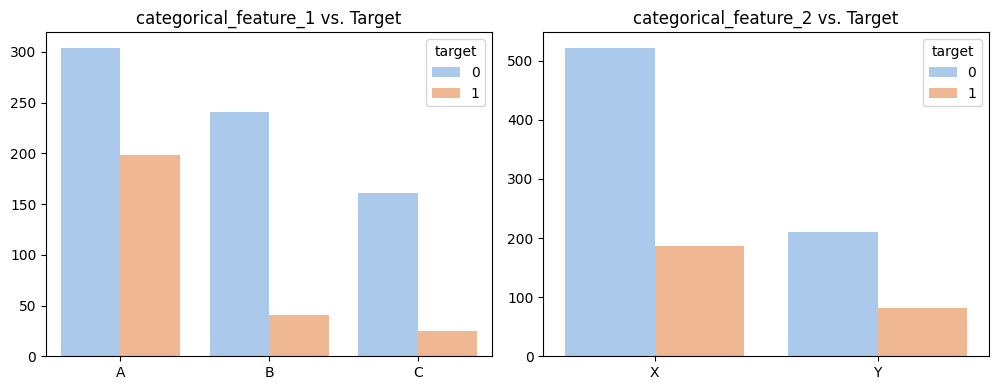


1.5f Stacked Conditional Proportion Plots (Numerical Features vs. Target - Sum = 1 per Bin):


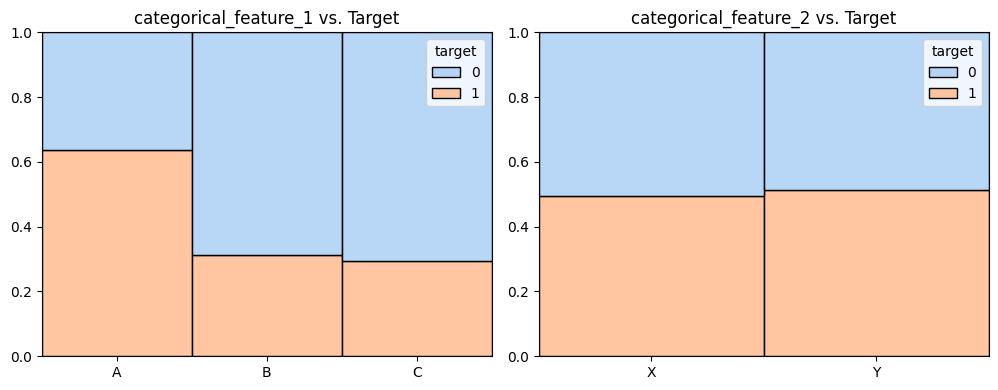

In [10]:
# 1.5c Bivariate Plots (Categorical Features vs. Target - Count Plots)
print("\n1.5e Bivariate Plots (Categorical Features vs. Target - Count Plots):")
fig_cat_biv, axes_cat_biv = get_axes_for_subplots(len(categorical_features), N_COLS_PER_ROW, fig_width_per_plot=5)
if fig_cat_biv:
    for i, col in enumerate(categorical_features):
        sns.countplot(x=X[col], hue=y, order=X[col].value_counts().index, ax=axes_cat_biv[i])
        axes_cat_biv[i].set_title(f'{col} vs. Target')
        axes_cat_biv[i].set_xlabel('')
        axes_cat_biv[i].set_ylabel('')
    fig_cat_biv.tight_layout()
    plt.show()

# 1.5c Bivariate Plots (Categorical Features vs. Target - Count Plots)
print("\n1.5f Stacked Conditional Proportion Plots (Numerical Features vs. Target - Sum = 1 per Bin):")
fig_cat_biv, axes_cat_biv = get_axes_for_subplots(len(categorical_features), N_COLS_PER_ROW, fig_width_per_plot=5)
if fig_cat_biv:
    for i, col in enumerate(categorical_features):
        sns.histplot(df, x=col, hue='target', kde=False, discrete=True, stat='percent', multiple='fill',
                     common_norm=False, bins=30, ax=axes_cat_biv[i])
        axes_cat_biv[i].set_title(f'{col} vs. Target')
        axes_cat_biv[i].set_xlabel('')
        axes_cat_biv[i].set_ylabel('')
    fig_cat_biv.tight_layout()
    plt.show()


1.6 Correlation Matrix:


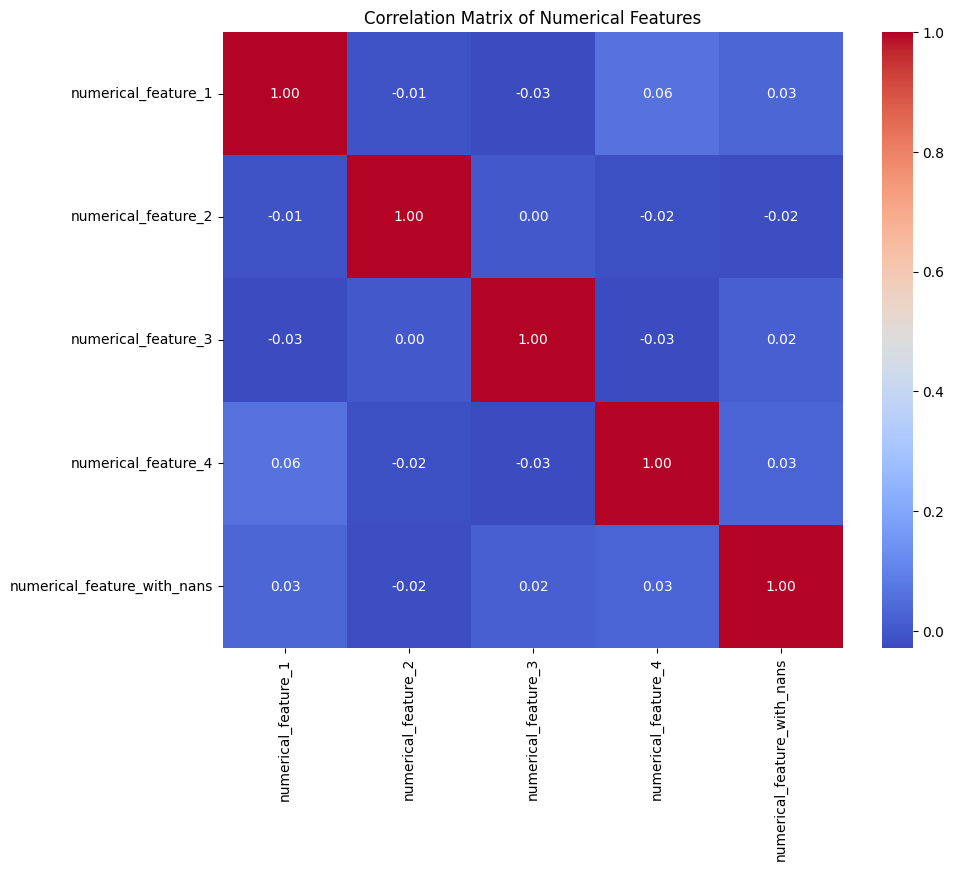

In [11]:
# 1.6 Correlation Matrix (for numerical features)
print("\n1.6 Correlation Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(X[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 2. Data Preprocessing Pipeline

This section outlines the steps to prepare the data for machine learning models, including handling missing values, scaling numerical features, and encoding categorical features. We use `ColumnTransformer` and `Pipeline` for a robust and reproducible preprocessing workflow.

In [12]:
print("\n\n--- 2. Data Preprocessing Pipeline ---")

# 2.1 Split Data into Training and Test Sets
# It's crucial to split *before* any scaling or complex imputation to prevent data leakage.
# `stratify=y` ensures that the train/test split has the same proportion of target classes as the original dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train distribution:\n{y_train.value_counts(normalize=True)}")
print(f"y_test distribution:\n{y_test.value_counts(normalize=True)}")

# 2.2 Define Preprocessing Steps for Numerical Features
# Imputation: How to handle missing values
#   - `SimpleImputer(strategy='mean')`: Replaces NaNs with the mean of the column. Good for normally distributed data.
#   - `SimpleImputer(strategy='median')`: Replaces NaNs with the median. Robust to outliers.
#   - `SimpleImputer(strategy='most_frequent')`: Replaces NaNs with the most frequent value. Good for categorical/skewed data.
#
# Scaling (Normalization):
#   - `StandardScaler()`: (Z-score normalization) Scales data to have zero mean and unit variance.
#     * When to use: Models that assume normally distributed features (e.g., Logistic Regression, SVMs, PCA, Neural Networks). Sensitive to outliers.
#   - `MinMaxScaler()`: Scales data to a fixed range, typically [0, 1].
#     * When to use: Algorithms sensitive to feature scale but not distribution shape (e.g., K-Nearest Neighbors, Neural Networks with sigmoid activation). Less sensitive to outliers than StandardScaler if range is small, but still influenced by them.
#   - `RobustScaler()`: Scales data using statistics that are robust to outliers (median and interquartile range).
#     * When to use: When your data contains many outliers.
#   - `Normalizer()`: Scales individual samples (rows) to have unit norm (L1 or L2).
#     * When to use: When you want to normalize across samples, not features (e.g., text features, specific distance-based algorithms). Not common for general feature scaling.

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Option 1: Mean imputation
    # ('imputer', SimpleImputer(strategy='median')), # Option 2: Median imputation
    ('scaler', StandardScaler()) # Option 1: Z-score scaling
    # ('scaler', MinMaxScaler()) # Option 2: Min-Max scaling
    # ('scaler', RobustScaler()) # Option 3: Robust scaling
])

# 2.3 Define Preprocessing Steps for Categorical Features
# Imputation:
#   - `SimpleImputer(strategy='most_frequent')`: Standard for categorical missing values.
# Encoding: How to convert categories to numbers
#   - `OneHotEncoder(handle_unknown='ignore')`: Creates a binary column for each category.
#     * When to use: When categories do not have an inherent order. Prevents models from assuming ordinality.
#     * `handle_unknown='ignore'` ensures new categories in test set don't cause errors.
#   - `OrdinalEncoder()`: Maps categories to integers (0, 1, 2...).
#     * When to use: When categories *do* have an inherent order (e.g., low, medium, high).
#     * *Caution*: Misleading for models if no inherent order.

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode
    # ('ordinal', OrdinalEncoder()) # Option for ordinal features
])

# 2.4 Create a Column Transformer to Apply Different Preprocessing to Different Columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("\nPreprocessing pipeline defined.")



--- 2. Data Preprocessing Pipeline ---
X_train shape: (800, 7)
X_test shape: (200, 7)
y_train distribution:
target
0    0.7325
1    0.2675
Name: proportion, dtype: float64
y_test distribution:
target
0    0.735
1    0.265
Name: proportion, dtype: float64

Preprocessing pipeline defined.


## 3. Model Training, Validation, and Hyperparameter Tuning

This section covers different strategies for training and evaluating machine learning models, including simple training, cross-validation, and hyperparameter tuning using `GridSearchCV` and `RandomizedSearchCV`.

In [13]:
print("\n\n--- 3. Model Training, Validation, and Hyperparameter Tuning ---")

# 3.1 Define Classifiers within a Pipeline
# We'll put the preprocessor and classifier into a single pipeline for convenience.
# This ensures that all preprocessing steps (imputation, scaling, encoding) are applied consistently
# to both training and test data, and within cross-validation.

# Example Classifier 1: Logistic Regression
clf_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Example Classifier 2: Random Forest
clf_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Example Classifier 3: Support Vector Machine (SVC)
clf_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42)) # probability=True for ROC curves
])

print("\nClassifiers initialized within pipelines.")

# --- Strategy 1: Simple Training & Evaluation ---
print("\n--- Strategy 1: Simple Training & Evaluation (Logistic Regression) ---")
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
y_proba_lr = clf_lr.predict_proba(X_test)[:, 1] # Probability of the positive class

print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Logistic Regression Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Logistic Regression Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"Logistic Regression F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_pred_lr))

# --- Strategy 2: Cross-Validation (More Robust Evaluation) ---
print("\n--- Strategy 2: Cross-Validation (Random Forest) ---")
# Cross-validation gives a more reliable estimate of model performance on unseen data
# by training and evaluating the model multiple times on different subsets of the training data.
# It helps detect overfitting to a single train-test split.

cv_scores = cross_val_score(clf_rf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1) # cv=5 for 5 folds
print(f"Random Forest Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Random Forest Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# --- Strategy 3: Hyperparameter Tuning with GridSearchCV ---
print("\n--- Strategy 3: Hyperparameter Tuning with GridSearchCV (Logistic Regression) ---")
# GridSearchCV performs an exhaustive search over a specified parameter grid,
# evaluating each combination using cross-validation. It's good for smaller grids.

# Define parameter grid for Logistic Regression
# Parameters are accessed via 'classifier__param_name' because the classifier is inside a pipeline
param_grid_lr = {
    'classifier__C': [0.1, 1, 10, 100], # Inverse of regularization strength
    'classifier__penalty': ['l1', 'l2'] # Regularization type
}

grid_search_lr = GridSearchCV(clf_lr, param_grid_lr, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)

print(f"Best parameters for Logistic Regression: {grid_search_lr.best_params_}")
print(f"Best F1-score (CV) for Logistic Regression: {grid_search_lr.best_score_:.4f}")

# Evaluate the best model on the test set
best_clf_lr = grid_search_lr.best_estimator_
y_pred_best_lr = best_clf_lr.predict(X_test)
print(f"Best Logistic Regression Test Accuracy: {accuracy_score(y_test, y_pred_best_lr):.4f}")
print(f"Best Logistic Regression Test F1-Score: {f1_score(y_test, y_pred_best_lr):.4f}")


# --- Strategy 4: Hyperparameter Tuning with RandomizedSearchCV ---
print("\n--- Strategy 4: Hyperparameter Tuning with RandomizedSearchCV (Random Forest) ---")
# RandomizedSearchCV samples a fixed number of parameter settings from specified distributions.
# It's more efficient for larger search spaces, as it can often find good solutions faster than GridSearchCV.

param_dist_rf = {
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(clf_rf, param_distributions=param_dist_rf, n_iter=10, cv=3, scoring='accuracy', random_state=42, n_jobs=-1, verbose=1)
random_search_rf.fit(X_train, y_train)

print(f"Best parameters for Random Forest: {random_search_rf.best_params_}")
print(f"Best Accuracy (CV) for Random Forest: {random_search_rf.best_score_:.4f}")

best_clf_rf = random_search_rf.best_estimator_
y_pred_best_rf = best_clf_rf.predict(X_test)
print(f"Best Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")



--- 3. Model Training, Validation, and Hyperparameter Tuning ---

Classifiers initialized within pipelines.

--- Strategy 1: Simple Training & Evaluation (Logistic Regression) ---
Logistic Regression Accuracy: 0.7800
Logistic Regression Precision: 0.6216
Logistic Regression Recall: 0.4340
Logistic Regression F1-Score: 0.5111

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       147
           1       0.62      0.43      0.51        53

    accuracy                           0.78       200
   macro avg       0.72      0.67      0.68       200
weighted avg       0.76      0.78      0.77       200


--- Strategy 2: Cross-Validation (Random Forest) ---
Random Forest Cross-Validation Accuracy Scores: [0.80625 0.8625  0.85625 0.88125 0.825  ]
Random Forest Mean CV Accuracy: 0.8463 (+/- 0.0540)

--- Strategy 3: Hyperparameter Tuning with GridSearchCV (Logistic Regression) ---
Fitting 3 folds fo

## 4. Plots to Check Quality of Training

Visualizations are critical for understanding model performance beyond single metrics. This section includes common plots like Confusion Matrix, ROC Curve, and Precision-Recall Curve.



--- 4. Plots to Check Quality of Training ---

4.1 Evaluation Plots (Confusion Matrix, ROC Curve, Precision-Recall Curve):


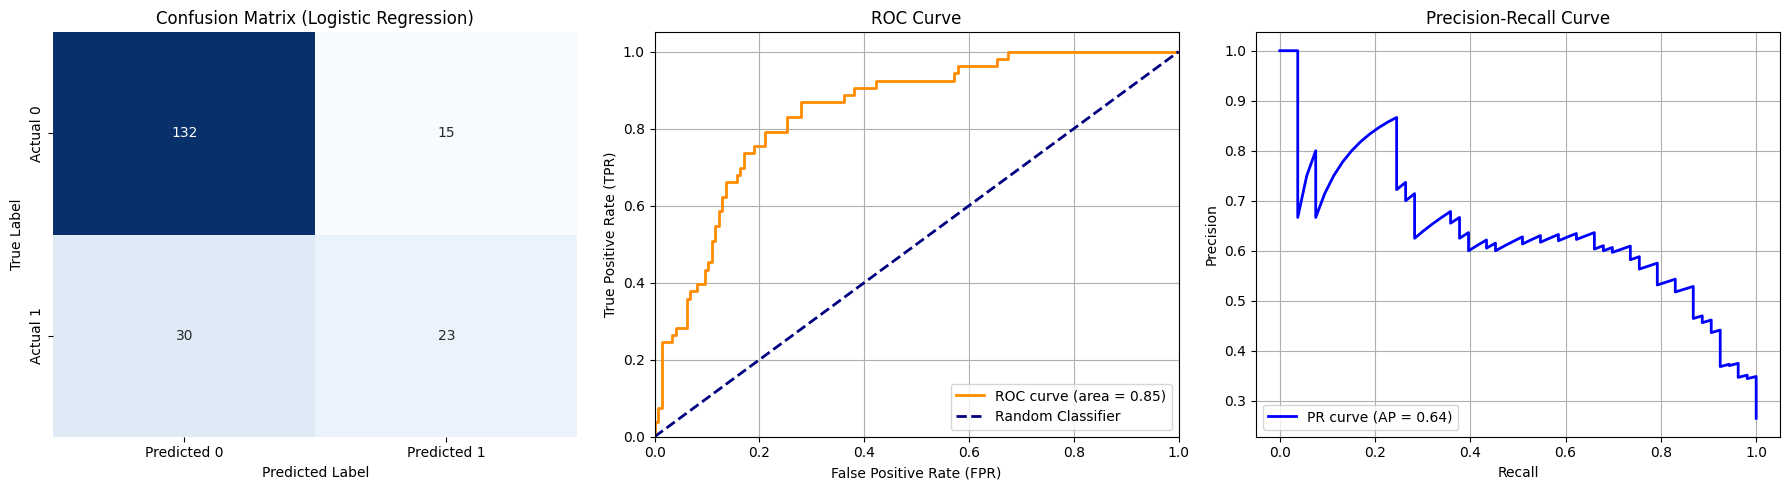


--- End of Sample Classification Workflow ---


In [14]:
print("\n\n--- 4. Plots to Check Quality of Training ---\n")

# We'll use the best_clf_lr (from GridSearchCV) as our example model for plotting

# 4.1 Plotting Confusion Matrix, ROC Curve, and Precision-Recall Curve in a single row
print("4.1 Evaluation Plots (Confusion Matrix, ROC Curve, Precision-Recall Curve):")

fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # 1 row, 3 columns for these specific plots

# --- Plot 1: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_best_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[0])
axes[0].set_title('Confusion Matrix (Logistic Regression)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# --- Plot 2: ROC Curve and AUC ---
y_proba_best_lr = best_clf_lr.predict_proba(X_test)[:, 1] # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best_lr)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate (FPR)')
axes[1].set_ylabel('True Positive Rate (TPR)')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True)

# --- Plot 3: Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_proba_best_lr)
average_precision = average_precision_score(y_test, y_proba_best_lr)

axes[2].plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve')
axes[2].legend(loc="lower left")
axes[2].grid(True)

plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

print("\n--- End of Sample Classification Workflow ---")